# 1. Setup and load data

In [69]:
# ====================================================
# Setup & Imports
# ====================================================



import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import warnings

import re
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,classification_report

from wordcloud import wordcloud,WordCloud
from collections import Counter

warnings.filterwarnings('ignore')


In [2]:
print('Loading Data ...')
df_train = pd.read_csv('/Users/victorhugo/Documents/Work/Data Science/Kaggle/Social Media/social-media-extremism-detection-challenge/train.csv')
df_test = pd.read_csv('/Users/victorhugo/Documents/Work/Data Science/Kaggle/Social Media/social-media-extremism-detection-challenge/test.csv')

print(f'\nData loaded :\nTrain {df_train.shape} , Test {df_test.shape}')


Loading Data ...

Data loaded :
Train (2250, 3) , Test (750, 2)


In [3]:
df_train = df_train.drop('ID' , axis = 1)

# 2. EDA

In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2250 entries, 0 to 2249
Data columns (total 2 columns):
 #   Column                            Non-Null Count  Dtype 
---  ------                            --------------  ----- 
 0   Original_Message,Extremism_Label  2249 non-null   object
 1   Extremism_Label                   2250 non-null   object
dtypes: object(2)
memory usage: 35.3+ KB


In [5]:
summary = pd.DataFrame({
    'data_type'      : df_train.dtypes,
    'Non-null-count' : df_train.notnull().sum(),
    'Missing values' : df_train.isna().sum(),
    ' Percentage of missing values' : df_train.isna().sum()/len(df_train),
    'Unique values' : df_train.nunique()
})

summary

,data_type,Non-null-count,Missing values,Percentage of missing values,Unique values
"Original_Message,Extremism_Label",object,2249,1,0.000444,2249
Extremism_Label,object,2250,0,0.000000,2


In [6]:
# Since there is only one missing data,i will drop it

# Check exactly where it is
print("Missing Original_Message:")
print(df_train[df_train['Original_Message,Extremism_Label'].isna()])
print(f"Total rows before: {len(df_train)}")

# Drop the row with missing text
df_train = df_train.dropna(subset=['Original_Message,Extremism_Label'])

print(f"Total rows after: {len(df_train)}")
print("Missing values check:")
print(df_train[['Original_Message,Extremism_Label', 'Extremism_Label']].isna().sum())



Missing Original_Message:
     Original_Message,Extremism_Label Extremism_Label
1228                              NaN   NON_EXTREMIST
Total rows before: 2250
Total rows after: 2249
Missing values check:
Original_Message,Extremism_Label    0
Extremism_Label                     0
dtype: int64


In [7]:
# Balanced Class
df_train['Extremism_Label'].value_counts(normalize= True)


Extremism_Label
EXTREMIST        0.510894
NON_EXTREMIST    0.489106
Name: proportion, dtype: float64

In [8]:
# Changing the target into 0 and 1

# Remove whitespace with strip and make sure it is all upper
df_train['Extremism_Label'] = df_train['Extremism_Label'].str.strip().str.upper()

label_map = {'EXTREMIST' :1 , 'NON_EXTREMIST':0}

df_train['Extremism_Label'] = df_train['Extremism_Label'].map(label_map)

In [9]:
df_train.head()

,"Original_Message,Extremism_Label",Extremism_Label
0,sixth forms should burn to the ground,1
1,whatever should burn benders to the ground,1
2,factories should burn to the ground,1
3,halal factories should burn to the ground,1
4,nhs should burn to the ground,1


In [10]:
df_train['Extremism_Label'].value_counts()

Extremism_Label
1    1149
0    1100
Name: count, dtype: int64

# 3. Pre-processing

Instead of using NLTK i will use scikit-learn library since it already lowercases the text, tokenizes and remove stopwords

but scikit-learn keeps the urls ,punctuation and numbers
re can handle the mess 

In [16]:
df_train['Original_Message,Extremism_Label']

0                   sixth forms should burn to the ground
1              whatever should burn benders to the ground
2                     factories should burn to the ground
3               halal factories should burn to the ground
4                           nhs should burn to the ground
                              ...                        
2245    my grandmother what a slut a maid those were t...
2246    lmao went off on the whore groupie hoe in scot...
2247    you are a major prick no woman should ever be ...
2248    in the current situation whatever cannot go ba...
2249    today whatever found out my wife what a slut p...
Name: Original_Message,Extremism_Label, Length: 2249, dtype: object

In [20]:
def simple_clean(text):
    text = str(text).lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)  # URLs
    text = re.sub(r'[^a-zA-Z\s]', ' ', text)             # Non-letters → space
    
    return ' '.join(text.split())                        # Collapse spaces

In [28]:
df_train['clean'] = df_train['Original_Message,Extremism_Label'].apply(simple_clean)
df_test['clean'] = df_test['Original_Message'].apply(simple_clean)


df_train['clean']

0                   sixth forms should burn to the ground
1              whatever should burn benders to the ground
2                     factories should burn to the ground
3               halal factories should burn to the ground
4                           nhs should burn to the ground
                              ...                        
2245    my grandmother what a slut a maid those were t...
2246    lmao went off on the whore groupie hoe in scot...
2247    you are a major prick no woman should ever be ...
2248    in the current situation whatever cannot go ba...
2249    today whatever found out my wife what a slut p...
Name: clean, Length: 2249, dtype: object

# 4. Modeling

4.1 Bag of Words (BoW)

4.2 TF-IDF

4.3 WORD2VEC (Embeddings)

In [23]:
# split data
X = df_train['clean']
y = df_train['Extremism_Label']

X_train , X_val, y_train ,y_val = train_test_split(X,y, test_size = 0.2 , random_state = 42, stratify=y)

In [62]:
# 4.1 Bag of Words (BoW)

bow = CountVectorizer(
    max_features = 5000,    # top 5000 words
    stop_words = 'english',
    ngram_range = (1,2)     # words + pairs  
)


# Learn vocabulary from train and apply into validation
X_train_bow = bow.fit_transform(X_train)
X_val_bow = bow.transform(X_val)

print("BoW Vocabulary size:", len(bow.get_feature_names_out()))

model = LogisticRegression()
model.fit(X_train_bow,y_train)

y_val_pred_bow = model.predict(X_val_bow)
accuracy_bow = accuracy_score(y_val,y_val_pred_bow)

print(f"\nBoW ACCURACY: {accuracy_bow:.3f}")


BoW Vocabulary size: 5000

BoW ACCURACY: 0.816


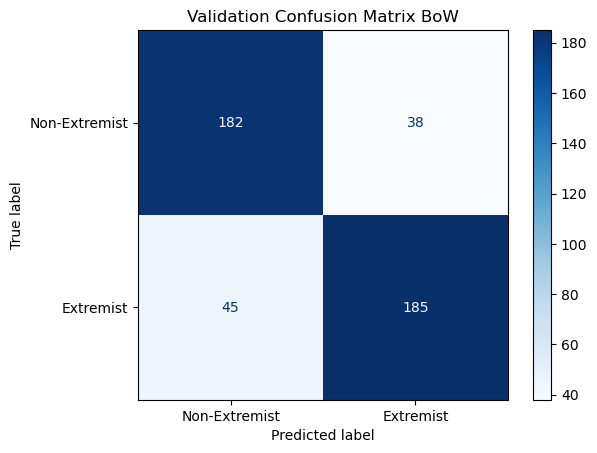

In [41]:
# Confusion matrix of BoW

cm = confusion_matrix(y_val,y_val_pred_bow)
disp = ConfusionMatrixDisplay(confusion_matrix=cm , display_labels = ['Non-Extremist', 'Extremist'])
disp.plot(cmap = plt.cm.Blues)
plt.title('Validation Confusion Matrix BoW')
plt.show()

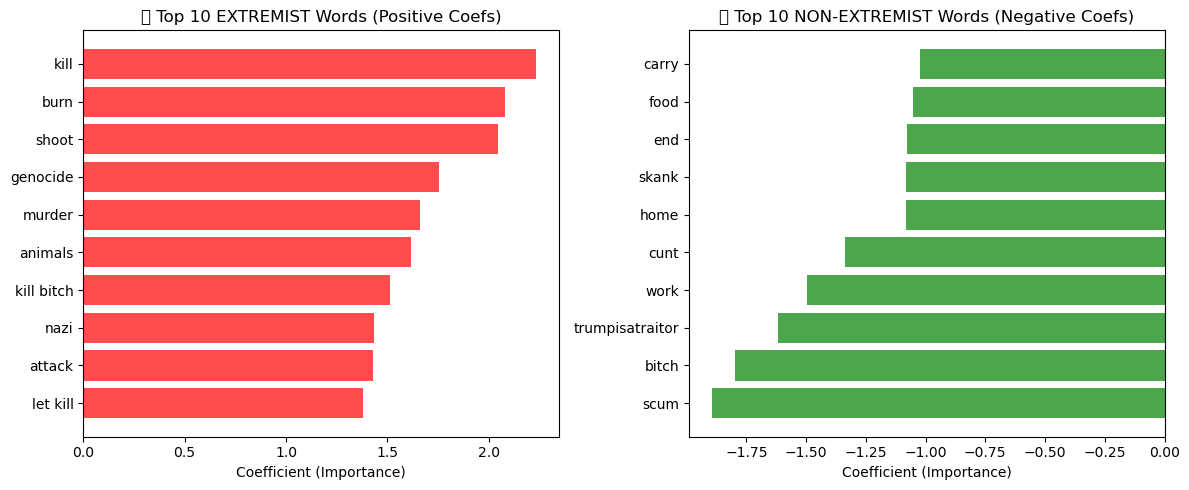

🔴 Top Extremist words: [('let kill', 1.38), ('attack', 1.43), ('nazi', 1.43), ('kill bitch', 1.51), ('animals', 1.62), ('murder', 1.66), ('genocide', 1.76), ('shoot', 2.04), ('burn', 2.08), ('kill', 2.23)]
🟢 Top Non-Extremist words: [('scum', -1.9), ('bitch', -1.8), ('trumpisatraitor', -1.62), ('work', -1.49), ('cunt', -1.34), ('home', -1.08), ('skank', -1.08), ('end', -1.08), ('food', -1.05), ('carry', -1.02)]


In [52]:
# Top 10 most important words from BoW 
feature_names = bow.get_feature_names_out()


# Get the weight of the labels for ex
# kill = +2.5
# muslins = +1.8
# love = -1.5
coefs = model.coef_[0]

# Top 10 POSITIVE (Extremist words)
top_pos_idx = np.argsort(coefs)[-10:]
top_pos_words = feature_names[top_pos_idx]
top_pos_coefs = coefs[top_pos_idx]

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.barh(range(10), top_pos_coefs, color='red', alpha=0.7)
plt.yticks(range(10), top_pos_words)
plt.title('🔴 Top 10 EXTREMIST Words (Positive Coefs)')
plt.xlabel('Coefficient (Importance)')

# Top 10 NEGATIVE (Non-Extremist words)
top_neg_idx = np.argsort(coefs)[:10]
top_neg_words = feature_names[top_neg_idx]
top_neg_coefs = coefs[top_neg_idx]

plt.subplot(1, 2, 2)
plt.barh(range(10), top_neg_coefs, color='green', alpha=0.7)
plt.yticks(range(10), top_neg_words)
plt.title('🟢 Top 10 NON-EXTREMIST Words (Negative Coefs)')
plt.xlabel('Coefficient (Importance)')
plt.tight_layout()
plt.show()

print("🔴 Top Extremist words:", list(zip(top_pos_words, top_pos_coefs.round(2))))
print("🟢 Top Non-Extremist words:", list(zip(top_neg_words, top_neg_coefs.round(2))))


In [55]:
df_train.columns

Index(['Original_Message,Extremism_Label', 'Extremism_Label', 'clean'], dtype='object')

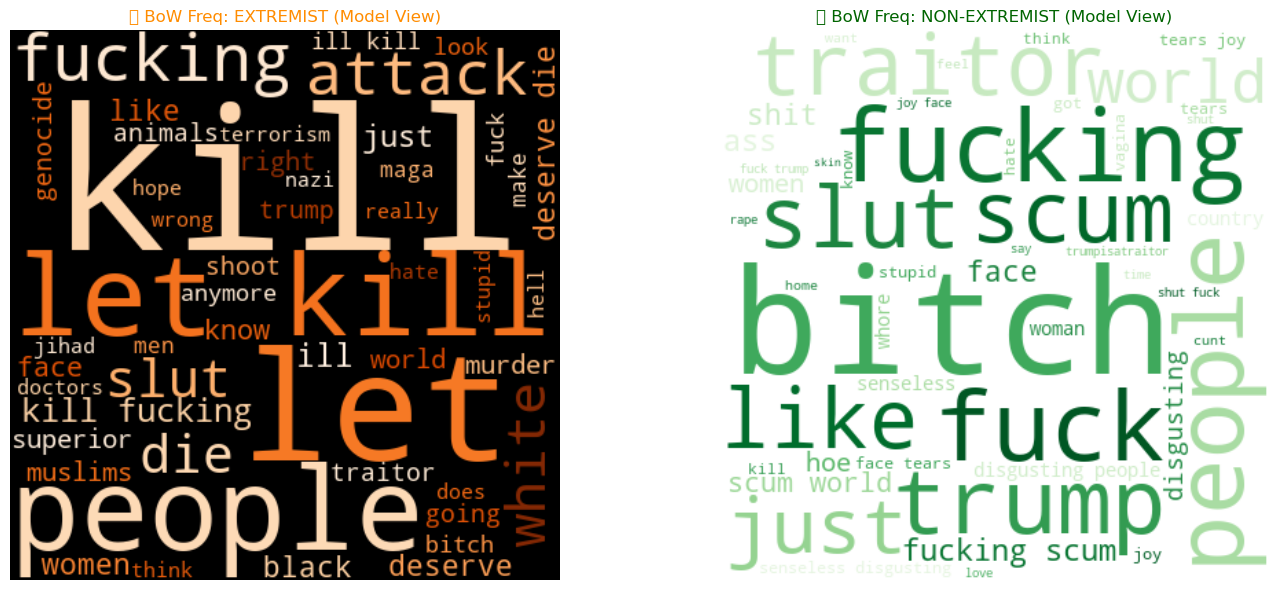

In [70]:
# Build frequency dicts per class from BoW
feature_names = bow.get_feature_names_out()

# Convert sparse matrix to dense only row‑by‑row to save memory
ext_freq = Counter()
nonext_freq = Counter()

for i in range(X_val_bow.shape[0]):
    row = X_val_bow[i].toarray().ravel()
    label = y_val.iloc[i]
    for j, cnt in enumerate(row):
        if cnt > 0:
            w = feature_names[j]
            if label == 1:          # extremist
                ext_freq[w] += cnt
            else:                   # non‑extremist
                nonext_freq[w] += cnt

#  Word clouds from frequencies
wc_bow_ext = WordCloud(width=400, height=400, background_color='black',
                       colormap='Oranges', max_words=50)
wc_bow_ext = wc_bow_ext.generate_from_frequencies(ext_freq)

wc_bow_non = WordCloud(width=400, height=400, background_color='white',
                       colormap='Greens', max_words=50)
wc_bow_non = wc_bow_non.generate_from_frequencies(nonext_freq)

plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.imshow(wc_bow_ext, interpolation='bilinear')
plt.axis('off')
plt.title('🟠 BoW Freq: EXTREMIST (Model View)', fontsize=12, color='darkorange')

plt.subplot(1, 2, 2)
plt.imshow(wc_bow_non, interpolation='bilinear')
plt.axis('off')
plt.title('🟢 BoW Freq: NON-EXTREMIST (Model View)', fontsize=12, color='darkgreen')

plt.tight_layout()
plt.show()

In [63]:
# 4.2 TF-IDF
tfidf = TfidfVectorizer(
    max_features = 5000,
    stop_words = 'english',
    ngram_range = (1,2)
)

X_train_tfidf = tfidf.fit_transform(X_train)
X_val_tfidf = tfidf.transform(X_val)

print("TF-IDF Vocabulary size:", len(tfidf.get_feature_names_out()))

# Train model

model_tfidf = LogisticRegression(
    max_iter= 1000,
    random_state = 42
)

model_tfidf.fit(X_train_tfidf,y_train)

# Evaluate

y_val_pred_tfidf = model_tfidf.predict(X_val_tfidf)
accuracy_tfidf = accuracy_score(y_val,y_val_pred_tfidf)

print(f"\nTF-IDF ACCURACY: {accuracy_tfidf:.3f}")
print(f"IMPROVEMENT: +{accuracy_tfidf - accuracy_bow:+.3f} from BoW")

TF-IDF Vocabulary size: 5000

TF-IDF ACCURACY: 0.829
IMPROVEMENT: ++0.013 from BoW


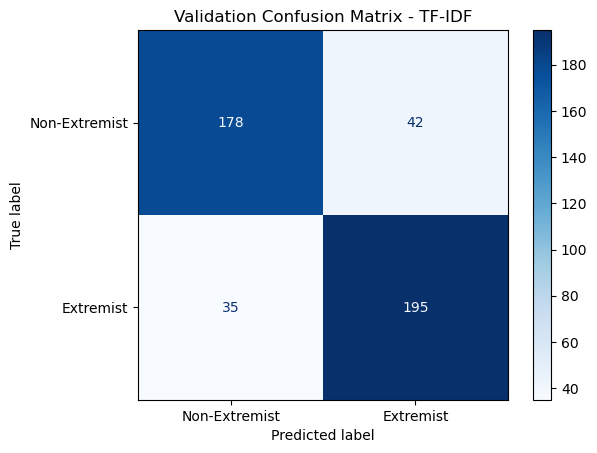

In [64]:
# Confusion matrix for TF-IDF
cm_tfidf = confusion_matrix(y_val, y_val_pred_tfidf)
disp_tfidf = ConfusionMatrixDisplay(confusion_matrix=cm_tfidf, display_labels=['Non-Extremist', 'Extremist'])
disp_tfidf.plot(cmap=plt.cm.Blues)
plt.title('Validation Confusion Matrix - TF-IDF')
plt.show()


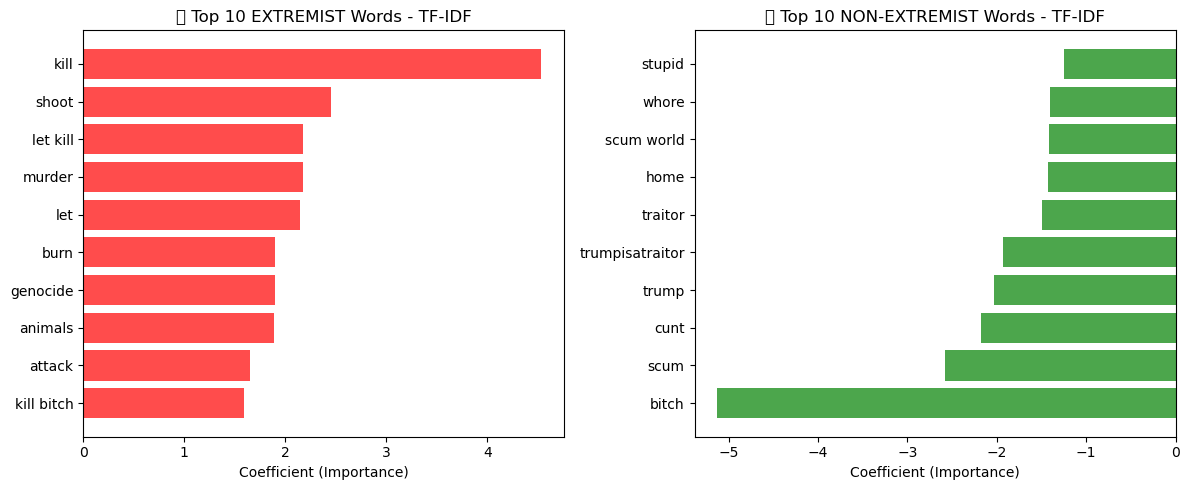

🔴 TF-IDF Top Extremist words: [('kill bitch', 1.59), ('attack', 1.66), ('animals', 1.88), ('genocide', 1.89), ('burn', 1.9), ('let', 2.15), ('murder', 2.17), ('let kill', 2.18), ('shoot', 2.45), ('kill', 4.53)]
🟢 TF-IDF Top Non-Extremist words: [('bitch', -5.13), ('scum', -2.58), ('cunt', -2.18), ('trump', -2.04), ('trumpisatraitor', -1.93), ('traitor', -1.49), ('home', -1.42), ('scum world', -1.42), ('whore', -1.41), ('stupid', -1.25)]


In [65]:
# Top 10 most important words from TF-IDF
feature_names_tfidf = tfidf.get_feature_names_out()
coefs_tfidf = model_tfidf.coef_[0]

# Top 10 POSITIVE (Extremist words)
top_pos_idx_tfidf = np.argsort(coefs_tfidf)[-10:]
top_pos_words_tfidf = feature_names_tfidf[top_pos_idx_tfidf]
top_pos_coefs_tfidf = coefs_tfidf[top_pos_idx_tfidf]

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.barh(range(10), top_pos_coefs_tfidf, color='red', alpha=0.7)
plt.yticks(range(10), top_pos_words_tfidf)
plt.title('🔴 Top 10 EXTREMIST Words - TF-IDF')
plt.xlabel('Coefficient (Importance)')

# Top 10 NEGATIVE (Non-Extremist words)
top_neg_idx_tfidf = np.argsort(coefs_tfidf)[:10]
top_neg_words_tfidf = feature_names_tfidf[top_neg_idx_tfidf]
top_neg_coefs_tfidf = coefs_tfidf[top_neg_idx_tfidf]

plt.subplot(1, 2, 2)
plt.barh(range(10), top_neg_coefs_tfidf, color='green', alpha=0.7)
plt.yticks(range(10), top_neg_words_tfidf)
plt.title('🟢 Top 10 NON-EXTREMIST Words - TF-IDF')
plt.xlabel('Coefficient (Importance)')
plt.tight_layout()
plt.show()

print("🔴 TF-IDF Top Extremist words:", list(zip(top_pos_words_tfidf, top_pos_coefs_tfidf.round(2))))
print("🟢 TF-IDF Top Non-Extremist words:", list(zip(top_neg_words_tfidf, top_neg_coefs_tfidf.round(2))))


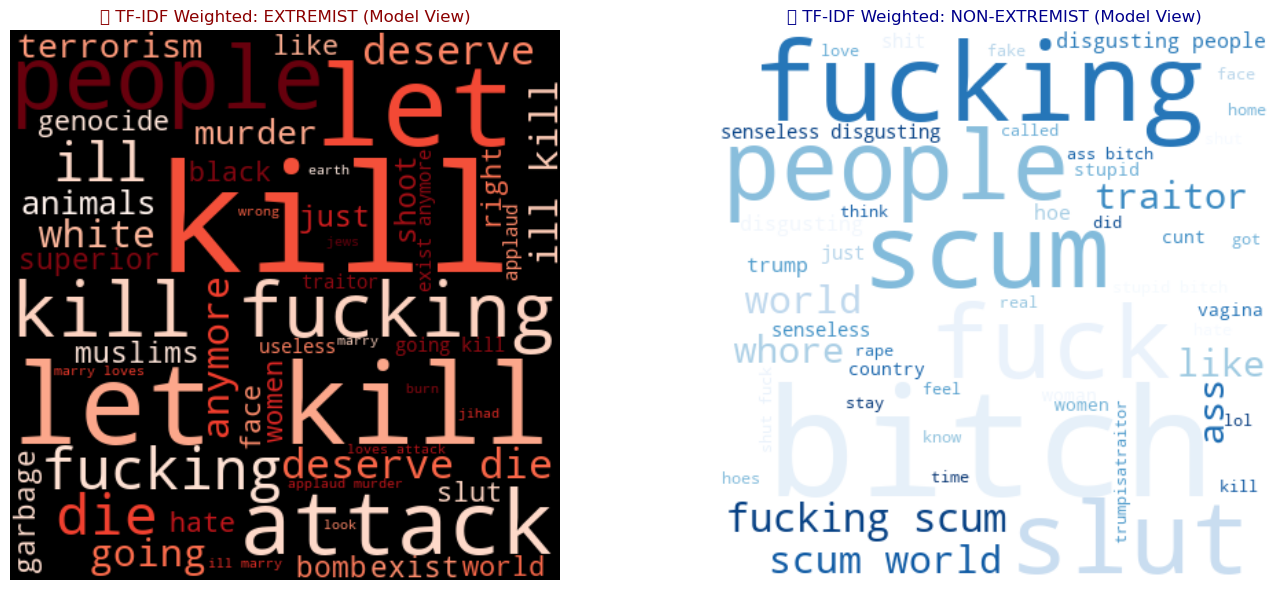

In [71]:
# TF‑IDF MODEL-WEIGHTED WORD CLOUDS (ONE WORD, SIZED BY WEIGHT)
feature_names_tfidf = tfidf.get_feature_names_out()

ext_freq_tfidf = Counter()
nonext_freq_tfidf = Counter()

# Iterate over validation rows
for i in range(X_val_tfidf.shape[0]):
    row = X_val_tfidf[i].toarray().ravel()
    label = y_val.iloc[i]
    for j, score in enumerate(row):
        if score > 0:                       # word appears with some TF‑IDF weight
            w = feature_names_tfidf[j]
            if label == 1:                  # extremist
                ext_freq_tfidf[w] += score  # accumulate TF‑IDF weight
            else:                           # non‑extremist
                nonext_freq_tfidf[w] += score

# Create word clouds from TF‑IDF frequencies
wc_model_ext = WordCloud(width=400, height=400, background_color='black',
                         colormap='Reds', max_words=50).generate_from_frequencies(ext_freq_tfidf)

wc_model_non = WordCloud(width=400, height=400, background_color='white',
                         colormap='Blues', max_words=50).generate_from_frequencies(nonext_freq_tfidf)

plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.imshow(wc_model_ext, interpolation='bilinear')
plt.axis('off')
plt.title('🔴 TF‑IDF Weighted: EXTREMIST (Model View)', fontsize=12, color='darkred')

plt.subplot(1, 2, 2)
plt.imshow(wc_model_non, interpolation='bilinear')
plt.axis('off')
plt.title('🟢 TF‑IDF Weighted: NON‑EXTREMIST (Model View)', fontsize=12, color='darkblue')

plt.tight_layout()
plt.show()


# Dataset Bias ! 

Words like bitch, hoe , ass , rape, scum , fucking scum appearing on non extremist


Why “bad” words appear in NON_EXTREMIST
	1.	Labels are about extremism, not toxicity.A post can be full of insults or sexual content (“bitch”, “hoe”, “rape”, “fucking scum”) and still be labeled NON_EXTREMIST if it does not clearly promote extremist ideology, organizations, or violence against protected groups.

	2.	The word clouds are class‑conditional frequencies.The NON_EXTREMIST cloud plotted uses only documents whose label is NON_EXTREMIST and sums TF‑IDF weights within that class.
	- If many NON_EXTREMIST posts in the dataset contain “bitch”, “ass”, “hoe”, then those words will be large in that cloud.
	- It does not mean the model thinks those words are “nice”, it only means: “among NON_EXTREMIST examples, these words are frequent / high‑TF‑IDF”.
    
	3.	Extremism vs generic hate / insult.The dataset clearly includes:
	- Generic insults / threats not tied to ideology → often labeled NON_EXTREMIST.
	- Explicit calls to genocide, targeting minorities, religious groups etc. → labeled EXTREMIST.So the model learns to focus on words/phrases that correlate with group‑targeted, ideological violence (“genocide”, “white purity”, “attack all muslims”), not every offensive term.


In [77]:
for w in ["bitch", "hoe", "ass", "rape", "scum", "fucking scum"]:
    if w in tfidf.vocabulary_:
        j = tfidf.vocabulary_[w]
        print(w, "→ coef:", model_tfidf.coef_[0][j])


bitch → coef: -5.126740414730188
hoe → coef: -0.7504622054539958
ass → coef: -0.8141867687359217
rape → coef: 0.13879867449979053
scum → coef: -2.5841075479302904
fucking scum → coef: -1.2224641770946467
